# Chapter 9 - Adding external variables to our model

`numpy`:  array manipulation (multiplication, division, etc.)

In [1]:
import numpy as np     
import matplotlib.pyplot as plt  # for plotting
import matplotlib.dates as mdates
import matplotlib as mpl
import pandas as pd     # table manipulation (DataFrame)
import itertools as itertls    # combinatorial
import statsmodels.api as sm_api    # statistics model that we used in our lecture

from tqdm import notebook
from typing import Union

from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

# To evaluate our model: MSE, MAE, MAPE
from sklearn.metrics import mean_squared_error, mean_absolute_error, \
                            mean_absolute_percentage_error


In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  "font.size": 16,
  "grid.alpha": 0.25})

**Function declarations**

In [39]:
def plot_time_series(x, y, xlabel="Time", ylabel="Value", figsize=(10, 4), 
                     use_date_locator=True, title=None, add_mark_at=None):
  fig, ax = plt.subplots(figsize=figsize)

  ax.plot(x, y)

  if use_date_locator:
    formatter = mdates.DateFormatter("%Y")
    # formatter = mdates.DateFormatter("%Y-%b")
    locator = mdates.YearLocator(base=4)
    # locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
    ax.xaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_locator(locator)
  
  if add_mark_at:
    x_loc, cycle_length = add_mark_at
    ax.plot(x[x_loc::cycle_length], y[x_loc::cycle_length], linestyle="None",
      marker='o', markerfacecolor='w', markeredgewidth=2, 
      markeredgecolor="tab:blue")

  ax.grid("on")
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)

  if title is not None:
    ax.set_title(title)

  if use_date_locator:
    for j, label in enumerate(ax.get_xticklabels()):
      label.set_rotation(40)
      label.set_horizontalalignment('right')

  plt.show(fig)


Get all U.S. macro economic data that is collected quarterly from 1959 to 2009

In [47]:
dir(sm_api.datasets.macrodata.load_pandas())

['__class__',
 '__class_getitem__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__ior__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__or__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__ror__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'clear',
 'copy',
 'data',
 'fromkeys',
 'get',
 'items',
 'keys',
 'names',
 'pop',
 'popitem',
 'raw_data',
 'setdefault',
 'update',
 'values']

In [4]:
macro_econ_data = sm_api.datasets.macrodata.load_pandas().data
macro_econ_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


Select only `realgdp`  

In [5]:
df_gdp = pd.DataFrame({"year": 
  pd.to_datetime([f"{int(y)}-{int(3*(q-1) + 1):02d}-01" for y, q in zip(
    macro_econ_data['year'],
    macro_econ_data['quarter']
  )]),
  "realgdp": macro_econ_data["realgdp"]})
df_gdp

,year,realgdp
0,1959-01-01,2710.349
1,1959-04-01,2778.801
2,1959-07-01,2775.488
3,1959-10-01,2785.204
4,1960-01-01,2847.699
...,...,...
198,2008-07-01,13324.600
199,2008-10-01,13141.920
200,2009-01-01,12925.410
201,2009-04-01,12901.504


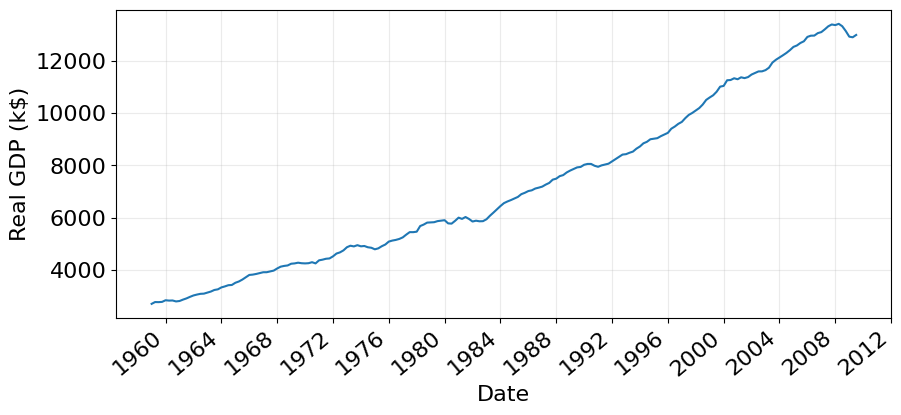

In [38]:
plot_time_series(df_gdp["year"], df_gdp["realgdp"],
                 xlabel="Date", ylabel="Real GDP (k$)")


The GDP is the total market value of all the finished goods and services  
produced within a country. The _real_ GDP is an inflation-adjusted measure  
that removes the impact of inflation on the market value of goods.

Definition of GDP
$$
  \textbf{GDP} = C + G + I + NX
$$
where $C$ is the sum of consumption, $G$ is government spending,  
$I$ is investments, and $NX$ is  net exports.

It is also possible that
- consumptions are impacted by employement rate and interest rates
- net exports are impacted by currency exchange rates

## 9.1 Examining the SARIMAX model

**SARIMAX model**   
The SARIMAX model simply adds a linear combination of exogenous variables to the   
SARIMA model. This allows us to model the impact of external variables on the   
future value of a time series

We can loosely defined the SARIMAX model as follows:
$$
y_t = \text{SARIMA}(p, d, q)(P, D, Q)_m + \sum^n_{i = 1} \beta_i X^i_t
$$

The SARIMAX model is the most general model for forecasting time series.  
You can see that if you have no seasonal patterns, it becomes an ARIMAX model.   
With no exogenous variables, it is a SARIMA model. With no seasonality or   
exogeneous variables, it becomes an ARIMA model.

### 9.1.1 Exploring the exogenous variables of the US macroeconomics dataset

Table 9.1: Description of all variables in the US macroeconomics dataset
| Variable | Description |
|----------|-------------|
| `realgdp` | Real gross domestic product (the target variable or endogenous variable) |
| `realcons` | Real personal consumption expenditure |
| `realinv` | Real gross private domestic investment |
| `realgovt` | Real federal consumption expenditure and investment |
| `realdpi` | Real private disposable income |
| `cpi` | Consumer price index for the end of the quarter | 
| `m1` | M1 nominal money stock |
| `tlilrate` | Quarterly monthly average of the monthly 3-month treasury bill |
| `unemp` | Unemployment rate |
| `pop` | Total population at the end of the quarter |
| `infl` | Inflation rate |
| `realint` | Real interest rate |

In [7]:
macro_econ_data.columns

Index(['year', 'quarter', 'realgdp', 'realcons', 'realinv', 'realgovt',
       'realdpi', 'cpi', 'm1', 'tbilrate', 'unemp', 'pop', 'infl', 'realint'],
      dtype='object')

We do not perform feature selection for simplification and use `realgdp` as   
the target variables and five exogenous variables [`realcons`, `realinv`, `realgovt`, `realdpi`, `cpi`]

In [8]:
selected_macro_econ_data = df_gdp.copy()
selected_macro_econ_data["realcons"] = macro_econ_data["realcons"].copy()
selected_macro_econ_data["realinv"] = macro_econ_data["realinv"].copy()
selected_macro_econ_data["realgovt"] = macro_econ_data["realgovt"].copy()
selected_macro_econ_data["realdpi"] = macro_econ_data["realdpi"].copy()
selected_macro_econ_data["cpi"] = macro_econ_data["cpi"].copy()

selected_macro_econ_data

,year,realgdp,realcons,realinv,realgovt,realdpi,cpi
0,1959-01-01,2710.349,1707.4,286.898,470.045,1886.9,28.980
1,1959-04-01,2778.801,1733.7,310.859,481.301,1919.7,29.150
2,1959-07-01,2775.488,1751.8,289.226,491.260,1916.4,29.350
3,1959-10-01,2785.204,1753.7,299.356,484.052,1931.3,29.370
4,1960-01-01,2847.699,1770.5,331.722,462.199,1955.5,29.540
...,...,...,...,...,...,...,...
198,2008-07-01,13324.600,9267.7,1990.693,991.551,9838.3,216.889
199,2008-10-01,13141.920,9195.3,1857.661,1007.273,9920.4,212.174
200,2009-01-01,12925.410,9209.2,1558.494,996.287,9926.4,212.671
201,2009-04-01,12901.504,9189.0,1456.678,1023.528,10077.5,214.469


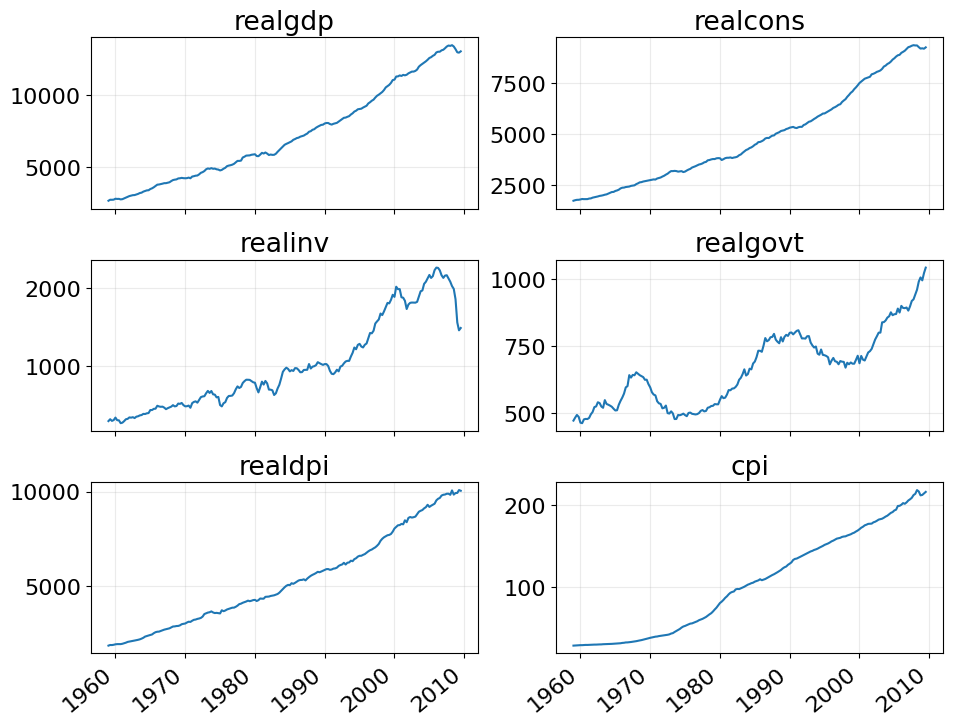

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(11, 8), sharex=True)

for (i, ax), col_name in zip(enumerate(axes.flatten()), ["realgdp", "realcons", "realinv", "realgovt", "realdpi", "cpi"]):
  ax.plot(selected_macro_econ_data["year"], selected_macro_econ_data[col_name])
  ax.set_title(col_name)
  ax.grid("on")

  if col_name in ["realdpi", "cpi"]:
    for j, label in enumerate(ax.get_xticklabels()):
      label.set_rotation(40)
      label.set_horizontalalignment('right')

plt.subplots_adjust(hspace=0.3, wspace=0.2)
plt.show(fig)


### 9.1.2 Caveat for using SARIMAX

Consider two time series `realgdp` and `realcons`. We consider `realcons` is   
our exogenous variable and we want to predict `realgdp`. Let our data  ends at   
the year 2009 and we do prediction at 2010 and 2011. Using SARIMAX we can only   
predict 2010 estimation for `realgdp`, because the prediction for 2011 needs  
the real value of `realoons` for `2010`. If our prediction is not so accurate   
in `2010` for `realcons`, our error will accumulate in `realgdp`.

In general we only have one timestep prediction unless we can predict accurately   
for the exogenous variable.


## 9.2 Forecasting the real GDP using the SARIMAX model

The general procedure for model selection of SARIMAX parameters is the same as  
SARIMA model except add `exog` variable in `SARIMAX()` function.   
See the implementation below for `optimize_SARIMAX()`

<img src="./figures/identify-nonstationary-general-procedure-sarimax.drawio.png" width=600>

Define target variable and exogenous variables

In [10]:
target = selected_macro_econ_data[["year", "realgdp"]]
exogenous = selected_macro_econ_data[["year", "realcons", "realinv", "realgovt", "realdpi", "cpi"]]

Test stationarity of our target variable

In [11]:
ADF_result = adfuller(target["realgdp"])
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: 1.7504627967647144
p-value: 0.9982455372335032


We apply first-differencing transformation

In [12]:
target_diff = np.diff(target["realgdp"], n=1)
ADF_result = adfuller(target_diff)
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: -6.305695561658106
p-value: 3.327882187668224e-08


Define `optimize_SARIMAX` to find the best combination of parameters with   
the lowest AIC. Look carefully to the `SARIMAX()` function, we add `exog` 
to include exogenous variable to the model.

In [13]:
def optimize_SARIMAX(endog: Union[pd.Series, list], 
                    exog: Union[pd.Series, list],
                    order_list: list, d: int, 
                    D: int, m: int,
                    enforce_stationarity: bool=True, 
                    enforce_invertibility: bool=True) -> pd.DataFrame:

  result = []
  # warnings.filterwarnings("error")   # handling warnings as error
  # warnings.resetwarnings()     # to reset warnings

  for order in notebook.tqdm(order_list):
    # print(f"{(order[0], order[1])}")
    try:
      model = SARIMAX(endog, exog, order=(order[0], d, order[1]),   # we add exog
                      seasonal_order=(order[2], D, order[3], m), 
                      simple_differencing=False, 
                      enforce_invertibility=enforce_invertibility,
                      enforce_stationarity=enforce_stationarity).fit(disp=False)
    except:
      continue

    aic = model.aic
    result.append([order, aic])

  
  result_df = pd.DataFrame(result)
  # print(result_df.columns)
  result_df.columns = ["(p,q,P,Q)", "AIC"]

  # Sort in ascending order, lower AIC is better
  result_df = result_df.sort_values(by="AIC", ascending=True).reset_index(drop=True)

  return result_df


Define the range of possible values for the orders $p$, $q$, $P$, and $Q$.   

In [14]:
p_space = range(0, 4, 1)
q_space = range(0, 4, 1)
P_space = range(0, 4, 1)
Q_space = range(0, 4, 1)

d = 1
D = 0
m = 4          # our data is given in a quarter for each year

sarimax_order_list = list(itertls.product(p_space, q_space, P_space, Q_space))
print(f"num. of possible paramters setting: {len(sarimax_order_list)}")
sarimax_order_list

num. of possible paramters setting: 256


[(0, 0, 0, 0),
 (0, 0, 0, 1),
 (0, 0, 0, 2),
 (0, 0, 0, 3),
 (0, 0, 1, 0),
 (0, 0, 1, 1),
 (0, 0, 1, 2),
 (0, 0, 1, 3),
 (0, 0, 2, 0),
 (0, 0, 2, 1),
 (0, 0, 2, 2),
 (0, 0, 2, 3),
 (0, 0, 3, 0),
 (0, 0, 3, 1),
 (0, 0, 3, 2),
 (0, 0, 3, 3),
 (0, 1, 0, 0),
 (0, 1, 0, 1),
 (0, 1, 0, 2),
 (0, 1, 0, 3),
 (0, 1, 1, 0),
 (0, 1, 1, 1),
 (0, 1, 1, 2),
 (0, 1, 1, 3),
 (0, 1, 2, 0),
 (0, 1, 2, 1),
 (0, 1, 2, 2),
 (0, 1, 2, 3),
 (0, 1, 3, 0),
 (0, 1, 3, 1),
 (0, 1, 3, 2),
 (0, 1, 3, 3),
 (0, 2, 0, 0),
 (0, 2, 0, 1),
 (0, 2, 0, 2),
 (0, 2, 0, 3),
 (0, 2, 1, 0),
 (0, 2, 1, 1),
 (0, 2, 1, 2),
 (0, 2, 1, 3),
 (0, 2, 2, 0),
 (0, 2, 2, 1),
 (0, 2, 2, 2),
 (0, 2, 2, 3),
 (0, 2, 3, 0),
 (0, 2, 3, 1),
 (0, 2, 3, 2),
 (0, 2, 3, 3),
 (0, 3, 0, 0),
 (0, 3, 0, 1),
 (0, 3, 0, 2),
 (0, 3, 0, 3),
 (0, 3, 1, 0),
 (0, 3, 1, 1),
 (0, 3, 1, 2),
 (0, 3, 1, 3),
 (0, 3, 2, 0),
 (0, 3, 2, 1),
 (0, 3, 2, 2),
 (0, 3, 2, 3),
 (0, 3, 3, 0),
 (0, 3, 3, 1),
 (0, 3, 3, 2),
 (0, 3, 3, 3),
 (1, 0, 0, 0),
 (1, 0, 0, 1),
 (1, 0, 0,

Separate between `train` and `test` for `target` and `exogenous`. We use   
196 data points for our training set and the rest as test set.   
This training set starts from 1959 to 2007 leaving 2008 and 2009 as test set

In [15]:
idx_split = 196
target_train = target.iloc[:idx_split] 
exogenous_train = exogenous.iloc[:idx_split]

target_test = target.iloc[idx_split:]
exogenous_test = exogenous.iloc[idx_split:]

Find the best model by selecting the lowest AIC

In [16]:
# # Computational time: 15 minutes 10 secs
# sarimax_result_df = optimize_SARIMAX(target_train["realgdp"], 
#                                     exogenous_train[["realcons", "realinv", "realgovt", "realdpi", "cpi"]], 
#                                     sarimax_order_list, d, D, m, 
#                                     enforce_invertibility=True, 
#                                     enforce_stationarity=True)

In [17]:
# sarimax_result_df.to_csv("./results/ch-09-sarimax-realgdp-result.csv", index=False)

In [18]:
reload_sarimax_result_df = pd.read_csv("./results/ch-09-sarimax-realgdp-result.csv")


Disply the sorted `DataFrame` in increasing order of AIC


In [19]:
reload_sarimax_result_df

,"(p,q,P,Q)",AIC
0,"(2, 3, 0, 0)",1703.605850
1,"(2, 3, 1, 0)",1705.397188
2,"(2, 3, 0, 1)",1705.485382
3,"(3, 3, 0, 0)",1705.492502
4,"(3, 2, 0, 0)",1707.005155
...,...,...
251,"(3, 2, 2, 1)",1727.955642
252,"(3, 2, 1, 2)",1728.040947
253,"(3, 2, 3, 3)",1728.185079
254,"(3, 2, 1, 3)",1728.620811


We select the model with the parameters $(p, d, q)(P, D, Q)_m = (2, 1, 3)(0, 0, 0)_4$.   
Notice that the seasonal component of the model has only orders of 0.   
This makes sense, as there is no visible seasonal pattern in the plot of real GDP.   
See the plot in the previous cells.


In [20]:
best_pqPQ = reload_sarimax_result_df["(p,q,P,Q)"].iloc[0]
best_sarimax_p, best_sarimax_q, best_sarimax_P, best_sarimax_Q \
  = tuple(map(int, best_pqPQ.strip("()").split(", ")))
print(f"best SARIMAX (p,d,q)(P,D,Q)_m: {(best_sarimax_p, d, best_sarimax_q)}" +\
  f"{(best_sarimax_P, D, best_sarimax_Q)}_{m}")

best SARIMAX (p,d,q)(P,D,Q)_m: (2, 1, 3)(0, 0, 0)_4


For the SARIMAX model we have to see that $p$-values of exogenous variables   
have nothing to do with relevance of the predictor. It only test if the   
estimated coefficients of linear regression are differ from zero or not.

In [21]:
model_sarimax_best = SARIMAX(target_train["realgdp"], 
                              exogenous_train[["realcons", "realinv", "realgovt", "realdpi", "cpi"]], 
                              order=(best_sarimax_p, d, best_sarimax_q), 
                              seasonal_order=(best_sarimax_P, D, best_sarimax_Q, m), 
                              simple_differencing=False)
model_sarimax_best_fit = model_sarimax_best.fit(disp=False)
print(model_sarimax_best_fit.summary())

/home/henokh/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                realgdp   No. Observations:                  196
Model:               SARIMAX(2, 1, 3)   Log Likelihood                -840.803
Date:                Thu, 19 Oct 2023   AIC                           1703.606
Time:                        11:49:56   BIC                           1739.609
Sample:                             0   HQIC                          1718.183
                                - 196                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
realcons       1.0030      0.049     20.650      0.000       0.908       1.098
realinv        1.0411      0.034     31.018      0.000       0.975       1.107
realgovt       0.7274      0.124      5.874      0.0

From the above table, we will notice that all exogenous variables have a $p$-value   
smaller than 0.05, except for `realdpi`, which has a $p$-value of 0.341.   
This means that the coefficient of `realdpi` is not significantly different from 0.  
We will also notice that its coefficient is -0.0284,   
Remember that the coefficient is kept in the model, as the $p$-value DOES NOT   
determine the relevance of this predictor in forecasting our target.

Next, we perform residual analysis

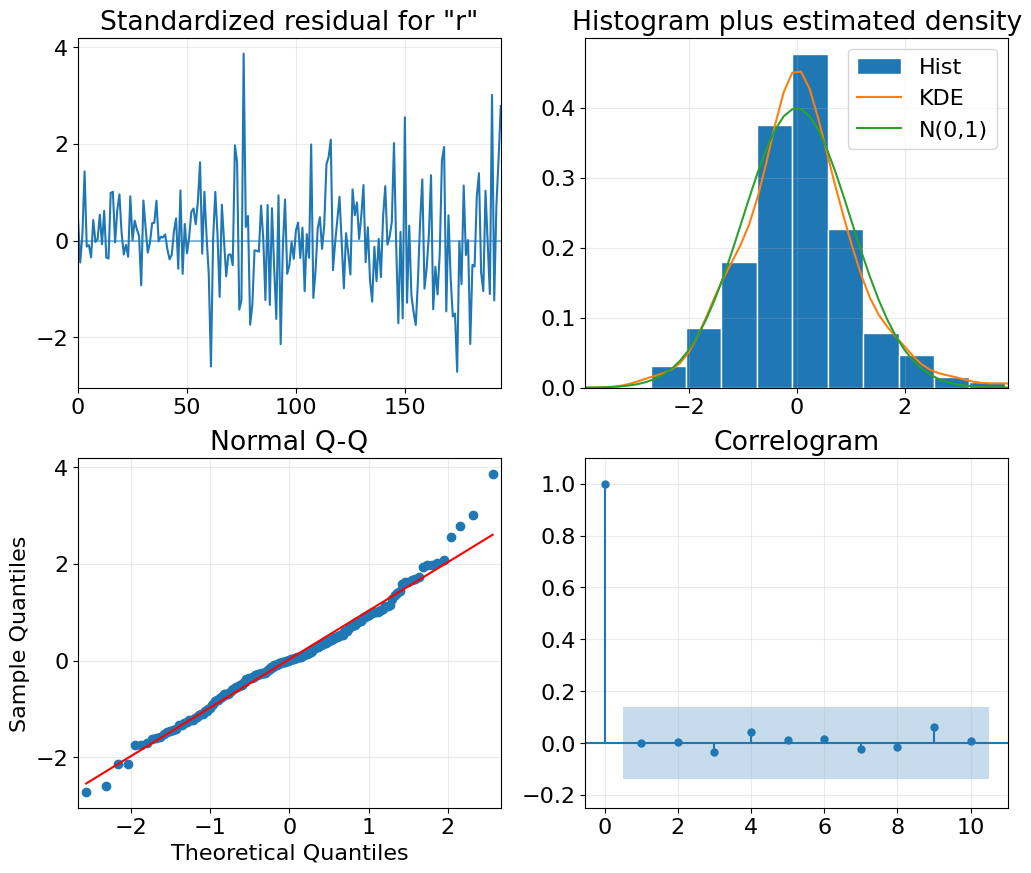

In [22]:
# qualitative test for the residual
fig = model_sarimax_best_fit.plot_diagnostics(figsize=(12, 10))

# get all axes
axs = fig.get_axes()
for ax in axs:
  ax.grid("on")

# set y-lim for correlogram plot
axs[3].set_ylim([-0.25, 1.1])
plt.show(fig)

Everything points to the residuals being completely random: standardized residual  
plot is stationary, histogram plot is close to the unit normal distribution,   
Q-Q plot follow the diagonal line, and correlogram points for all lags 
are inside the significant level.

Now we apply Ljung-Box test to make sure that the residuals are independent
and uncorrelated.

In [23]:
# Quantitative test for the residual
residuals = model_sarimax_best_fit.resid
ljung_box_test = acorr_ljungbox(residuals, np.arange(1, 11))
ljung_box_test


,lb_stat,lb_pvalue
1,0.063680,0.800772
2,0.121629,0.940998
3,0.147770,0.985545
4,1.232413,0.872734
5,1.232845,0.941688
6,1.235141,0.975113
7,1.353690,0.986948
8,1.370521,0.994655
9,1.516415,0.997023
10,1.519640,0.998873


All the $p$-values are greater than 0.05. Therefore we do not reject the null  
hypothesis, and we conclude that the residuals are independent and uncorrelated.

Because of the problem in SARIMAX that we can only predict one timestep   
at prediction, then we have to use rolling forecast to forecast the date   
in test set.

In [24]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, 
                      method: str, 
                      target_column_name: str, 
                      exogenous_column_name: Union[list, str] = None,
                      sarimax_order: tuple = None) -> list:
  """
  The following models using all the dataframe (train + test),
  because we roll out forecast with a correct data with the length
  of forecast is equal to `horizon`
  """
  total_len = train_len + horizon

  if method == "last":
    pred_last_value = []

    for i in range(train_len, total_len, window):
      last_value = df[:i][target_column_name].iloc[-1]
      pred_last_value.extend(last_value for _ in range(window))

    return pred_last_value

  elif method == "SARIMAX":
    pred_SARIMAX = []

    for i in range(train_len, total_len, window):
      model = SARIMAX(df[:i][target_column_name], df[:i][exogenous_column_name], 
                      order=sarimax_order[:3],
                      seasonal_order=sarimax_order[3:], 
                      simple_differencing=False)
      res = model.fit(disp=False)
      predictions = res.get_prediction(exog=df[:i][exogenous_column_name])
      oos_pred = predictions.predicted_mean.iloc[-window:]   # oos: output of sarimax
      pred_SARIMAX.extend(oos_pred)

    return pred_SARIMAX


In [25]:
df_test_pred = target[idx_split:].copy()

TRAIN_LEN = len(target_train)
HORIZON = len(target_test)
WINDOW = 1      # from the fact that SARIMAX at best predict one timestep

pred_last_value = rolling_forecast(selected_macro_econ_data, TRAIN_LEN, HORIZON, WINDOW, 
                                    "last", "realgdp")
pred_sarimax = rolling_forecast(selected_macro_econ_data, TRAIN_LEN, HORIZON, WINDOW, 
                              "SARIMAX", "realgdp", 
                              ["realcons", "realinv", "realgovt", "realdpi", "cpi"],
                              sarimax_order=(best_sarimax_p, d, best_sarimax_q,
                                            best_sarimax_P, D, best_sarimax_Q, m))

df_test_pred["pred_last_value"] = pred_last_value
df_test_pred["pred_sarimax"] = pred_sarimax

df_test_pred.head()


/home/henokh/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/henokh/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/henokh/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/henokh/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/henokh/miniconda3/lib/python3.11/site-packages/statsmo

,year,realgdp,pred_last_value,pred_sarimax
196,2008-01-01,13366.865,13391.249,13341.394928
197,2008-04-01,13415.266,13366.865,13373.264703
198,2008-07-01,13324.600,13415.266,13370.809119
199,2008-10-01,13141.920,13324.600,13342.819197
200,2009-01-01,12925.410,13141.920,13134.351469


Plot the comparision between SARIMAX and last value model

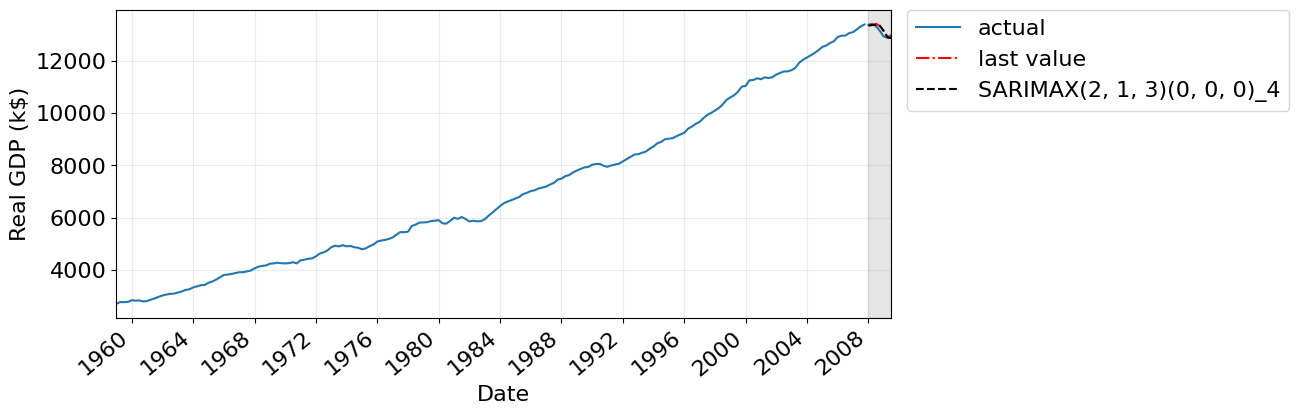

In [26]:
start_idx = 0  # for better visualization
xlim = [target_train["year"].iloc[start_idx], target_test["year"].iloc[-1]]

fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(target_train["year"], target_train["realgdp"])
ax.plot(target_test["year"], target_test["realgdp"], color="tab:blue", label="actual")

formatter = mdates.DateFormatter("%Y")
# formatter = mdates.DateFormatter("%Y-%b-%d")
locator = mdates.YearLocator(base=4)
# locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 4))
# locator = mdates.DayLocator()
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)
# ax.set_ylim([-0.5, 17])
ax.set_xlim(xlim)
ax.grid("on")
ax.set_xlabel("Date")
ax.set_ylabel("Real GDP (k$)")

# -- prediction
ax.plot(df_test_pred["year"], df_test_pred["pred_last_value"], "r-.", label="last value")
str_label = f"SARIMAX{best_sarimax_p, d, best_sarimax_q}" \
  + f"{best_sarimax_P, D, best_sarimax_Q}_{m}"
ax.plot(df_test_pred["year"], df_test_pred["pred_sarimax"], "k--", 
  label=str_label)

# add forecast area
ax.axvspan(target_test['year'].iloc[0], target_test['year'].iloc[-1], 
                color="#808080", alpha=0.2)

for j, label in enumerate(ax.get_xticklabels()):
  label.set_rotation(40)
  label.set_horizontalalignment('right')

# -- add legend in the second row
ax.legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

plt.show(fig)


Zoom in the forecast area

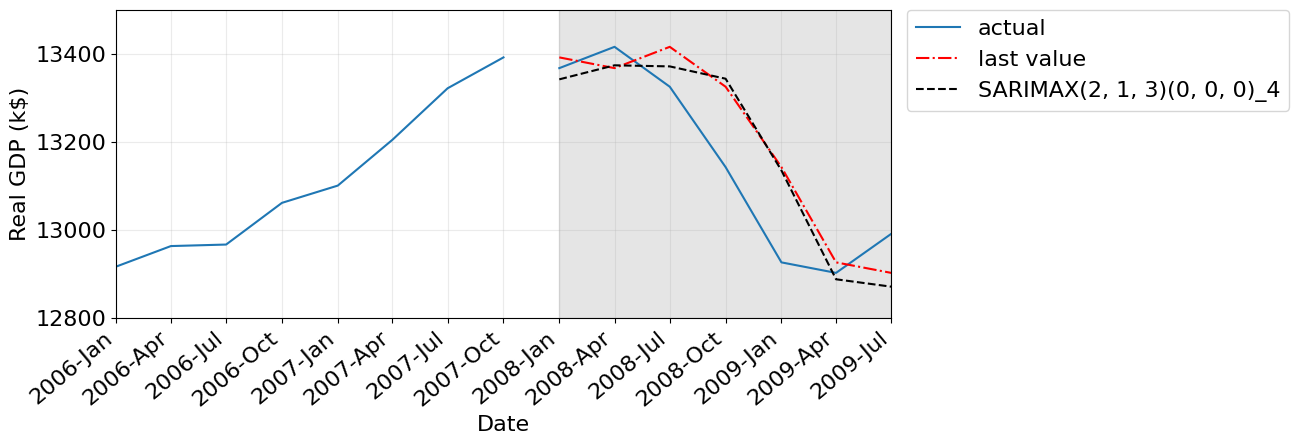

In [27]:
start_idx = 188  # for better visualization
xlim = [target_train["year"].iloc[start_idx], target_test["year"].iloc[-1]]

fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(target_train["year"], target_train["realgdp"])
ax.plot(target_test["year"], target_test["realgdp"], color="tab:blue", label="actual")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# formatter = mdates.DateFormatter("%Y-%b-%d")
# locator = mdates.YearLocator(base=4)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 3))
# locator = mdates.DayLocator()
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)
ax.set_ylim([12_800, 13_500])
ax.set_xlim(xlim)
ax.grid("on")
ax.set_xlabel("Date")
ax.set_ylabel("Real GDP (k$)")

# -- prediction
ax.plot(df_test_pred["year"], df_test_pred["pred_last_value"], "r-.", label="last value")
str_label = f"SARIMAX{best_sarimax_p, d, best_sarimax_q}" \
  + f"{best_sarimax_P, D, best_sarimax_Q}_{m}"
ax.plot(df_test_pred["year"], df_test_pred["pred_sarimax"], "k--", 
  label=str_label)

# add forecast area
ax.axvspan(target_test['year'].iloc[0], target_test['year'].iloc[-1], 
                color="#808080", alpha=0.2)

for j, label in enumerate(ax.get_xticklabels()):
  label.set_rotation(40)
  label.set_horizontalalignment('right')

# -- add legend in the second row
ax.legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

plt.show(fig)


Evalute the three models

In [28]:
mape_last    = mean_absolute_percentage_error(df_test_pred["realgdp"], df_test_pred["pred_last_value"]) * 100
mape_sarimax = mean_absolute_percentage_error(df_test_pred["realgdp"], df_test_pred["pred_sarimax"]) * 100

print(f"   MAPE last: {mape_last:.3f}%")
print(f"MAPE SARIMAX: {mape_sarimax:.3f}%")


   MAPE last: 0.737%
MAPE SARIMAX: 0.719%


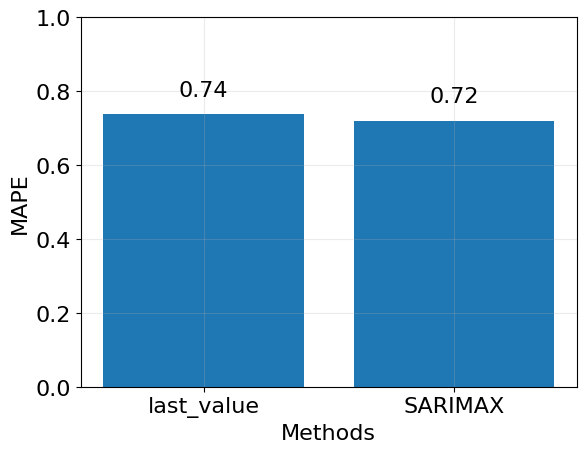

In [29]:
fig, ax = plt.subplots()

x_array = ["last_value", "SARIMAX"]
y_array = [mape_last, mape_sarimax]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAPE")
ax.set_ylim([0, 1])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+0.05, s=f"{val:.2f}", ha="center")

plt.show(fig)


In the figure above, we see that the SARIMAX model is the winning model by only  
0.02%. We will appreciate the importance of a baseline here, as both methods  
achieve an extremely low MAPE, showing that the SARIMAX model is only slightly  
bettern than simply predicting the last value.  
This is where the business context comes into play. In our case, since we are  
predicting the real GDP of the United States, a difference of 0.04% represents  
thousands of dollars.   
This difference might be relevant in this particular context, justifying the use  
of the SARIMAX model, even though it is only slightly bettern than the baseline.

## 9.3 Next steps

In a situation where we wish to show that two variables varying in time can   
impact one another, we must use the _vector autoregression_ (VAR) model.  
This model allows for multivariate time series forecasting, unlike the SARIMAX  
model, which is for univariate time series forecasting. 